In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [3]:
train.tail(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


##### 데이터 전처리
- date 분리 : date / month / weekday / time 추가
- distance 추가

##### date 분리 : date / month / weekday / time 추가

In [4]:
pickup_datetime_dt = pd.to_datetime(train["pickup_datetime"])
dropoff_datetime_dt = pd.to_datetime(train["dropoff_datetime"])

train["pickup_datetime"] = pickup_datetime_dt   #datetime64 형식으로 바꿔줌
train["dropoff_datetime"] = dropoff_datetime_dt #datetime64 형식으로 바꿔줌

train["pickup_date"] = train["pickup_datetime"].dt.date              #date only
train["dropoff_date"] = train["dropoff_datetime"].dt.date            #date only

train["pickup_month"] = train["pickup_datetime"].dt.month            #month only
train["dropoff_month"] = train["dropoff_datetime"].dt.month          #month only

train["pickup_weekday"] = train["pickup_datetime"].dt.weekday        #weekday only (요일)
train["dropoff_weekday"] = train["dropoff_datetime"].dt.weekday      #weekday only (요일)

train["pickup_hour"] = train["pickup_datetime"].dt.hour              #hour only
train["dropoff_hour"] = train["dropoff_datetime"].dt.hour            #hour only

##### distance 추가

In [5]:
### 승하차 위치 데이터 tuple로 묶기 - pickup_loc / dropoff_loc로 리턴

In [6]:
pickup_lat = tuple(train["pickup_latitude"])
pickup_lng = tuple(train["pickup_longitude"])
dropoff_lat = tuple(train["dropoff_latitude"])
dropoff_lng = tuple(train["dropoff_longitude"])

In [7]:
pickup_loc = tuple(zip(pickup_lat, pickup_lng))
dropoff_loc = tuple(zip(dropoff_lat, dropoff_lng))

In [8]:
len(pickup_loc), len(dropoff_loc)

(1458644, 1458644)

In [9]:
### pickup_loc & dropoff_loc 으로 직선거리 구하기

In [10]:
distance = []
for i in range(len(pickup_loc)):
    distance.append(haversine(pickup_loc[i], dropoff_loc[i]))

In [11]:
train["distance"] = distance

In [12]:
len(distance)

1458644

In [13]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.516818e+00,3.517178e+00,3.050375e+00,3.054422e+00,1.360648e+01,1.359890e+01,3.440864e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.681038e+00,1.681217e+00,1.954039e+00,1.956599e+00,6.399693e+00,6.483682e+00,4.296538e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00,1.231837e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,1.400000e+01,1.400000e+01,2.093717e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.900000e+01,1.900000e+01,3.875337e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,7.000000e+00,6.000000e+00,6.000000e+00,2.300000e+01,2.300000e+01,1.240909e+03


### regression analysis - categorial data
- passenger_count
- vendor_id
- store_and_fwd_flag

### 1. passenger_count

##### passenger_count - 1-1. OLS - w/ trip_duration
- R-squared : 0으로 상관 없어보임.

In [14]:
model_pc1 = sm.OLS.from_formula("trip_duration ~ passenger_count", train)
result_pc1 = model_pc1.fit()
print(result_pc1.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     104.7
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           1.44e-24
Time:                        03:32:09   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458642   BIC:                         2.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         903.3010      6.998    1

##### passenger_count - 1-2. hat_matrix(레버리지 계산) - w/ trip_duration

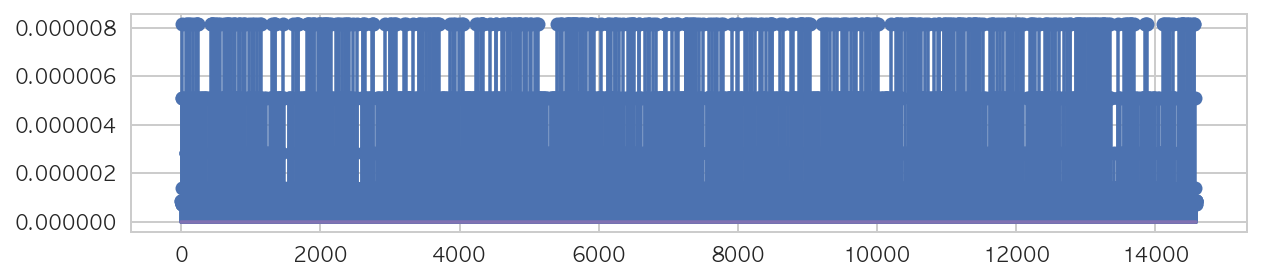

In [15]:
influence = result_pc1.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat[::100])
plt.show()

##### passenger_count - 1-3. joint plot - w/ trip_duration
- 좀 더 명확하게 승객수 간 duration차이를 보기위에 일부 데이터 제거 (trip_duration > 7200)
- joint_plot결과, 승객수 간 trip_duration차이 없음

In [16]:
idx1 = np.where(train["trip_duration"]>7200)
idx1

(array([    531,    1134,    1865, ..., 1457207, 1457752, 1458076]),)

In [17]:
train1 = train.drop(train.index[idx1])

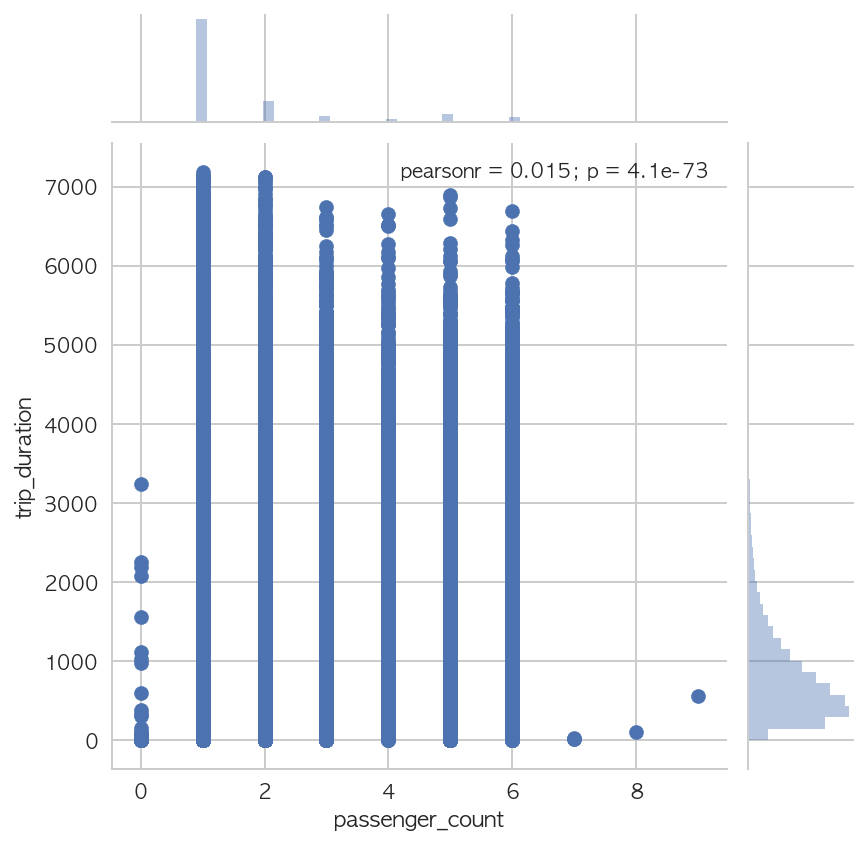

In [18]:
sns.jointplot(x="passenger_count", y="trip_duration", data=train1)
plt.show()

##### passenger_count - 2-1. OLS - w/ distance
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [19]:
model_pc2 = sm.OLS.from_formula("distance ~ passenger_count", train)
result_pc2= model_pc2.fit()
print(result_pc2.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     154.9
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           1.46e-35
Time:                        03:34:24   Log-Likelihood:            -4.1961e+06
No. Observations:             1458644   AIC:                         8.392e+06
Df Residuals:                 1458642   BIC:                         8.392e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.3848      0.006    5

##### passenger_count - 2-2. hat_matrix(레버리지 계산) - w/ distance

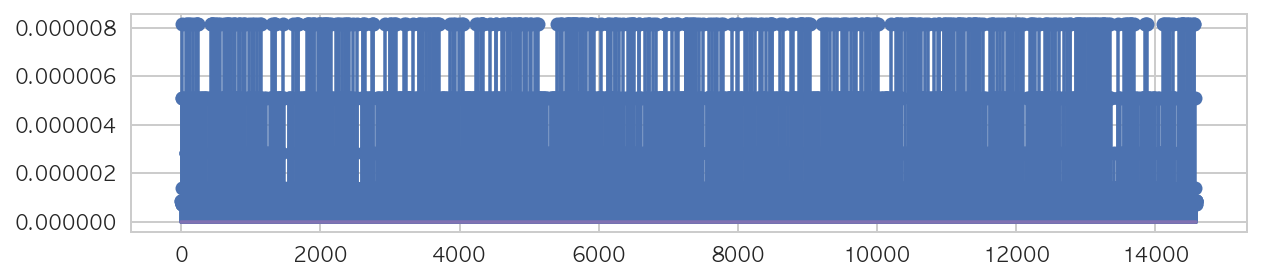

In [20]:
influence = result_pc2.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat[::100])
plt.show()

##### passenger_count - 2-3. joint plot - w/ trip_duration
- 좀 더 명확하게 승객수 간 distance차이를 보기위에 일부 데이터 제거 (distance > 600)
- joint_plot결과, 승객수 간 distance 차이는 달라보이지 않음.

In [21]:
idx2 = np.where(train["distance"]>600)
idx2

(array([184925, 974378]),)

In [22]:
train2 = train.drop(train.index[idx2])

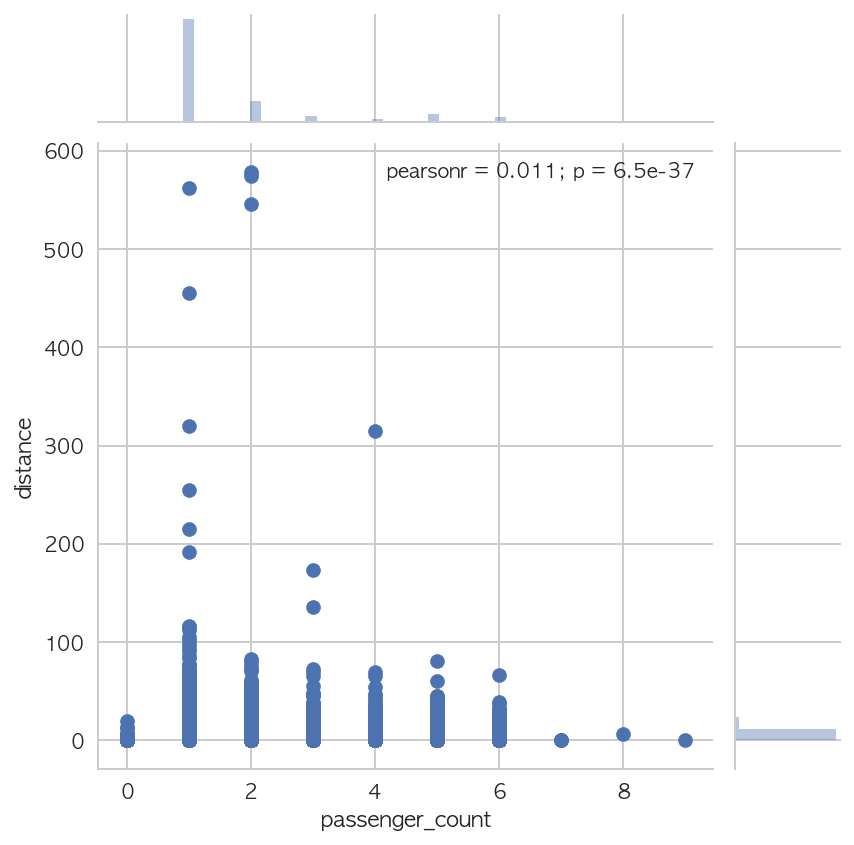

In [23]:
sns.jointplot(x="passenger_count", y="distance", data=train2)
plt.show()

##### passenger_count - 3-1. OLS - w/ pickup_hour
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [31]:
model_pc3 = sm.OLS.from_formula("pickup_hour ~ passenger_count", train)
result_pc3= model_pc2.fit()
print(result_pc3.summary())

                            OLS Regression Results                            
Dep. Variable:           pickup_month   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.700
Date:                Thu, 08 Mar 2018   Prob (F-statistic):            0.00964
Time:                        03:58:03   Log-Likelihood:            -2.8274e+06
No. Observations:             1458644   AIC:                         5.655e+06
Df Residuals:                 1458642   BIC:                         5.655e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5214      0.002   15

##### passenger_count - 3-2. joint plot - w/ pickup_hour
- joint_plot결과, 승객수 간 승차 시각 차이는 달라보이지 않음.

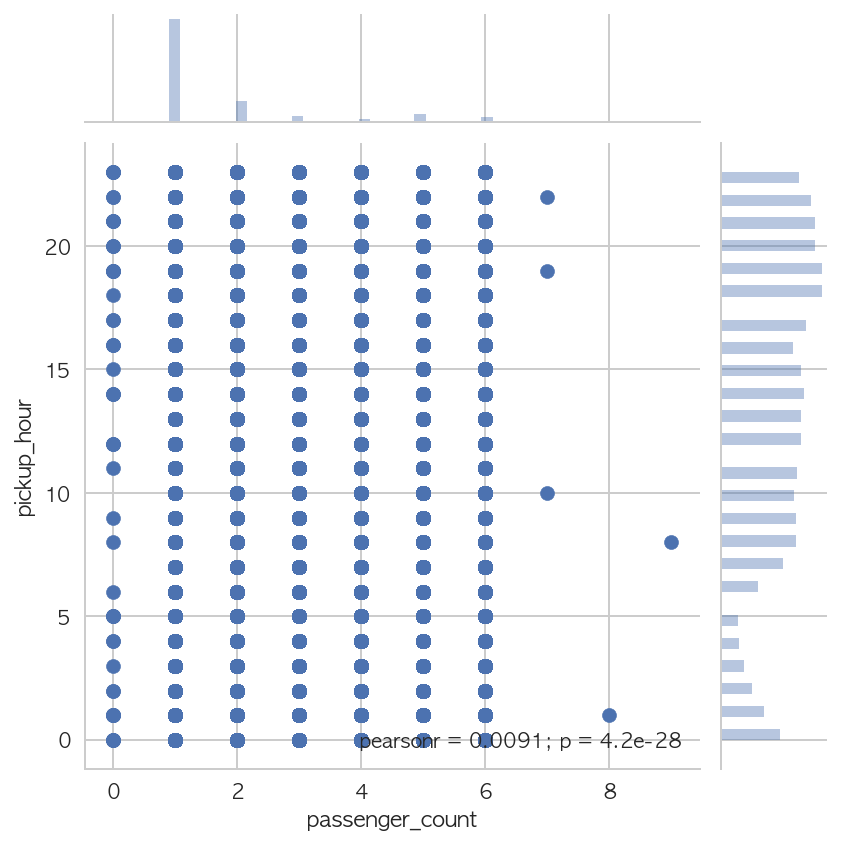

In [26]:
sns.jointplot(x="passenger_count", y="pickup_hour", data=train)
plt.show()

##### passenger_count - 3-3. OLS - w/ pickup_weekday
- OLS상으로 R-Squared = 0.001, 연관성 거의 없어 보임.

In [32]:
model_pc4 = sm.OLS.from_formula("pickup_weekday ~ passenger_count", train)
result_pc4= model_pc2.fit()
print(result_pc4.summary())

                            OLS Regression Results                            
Dep. Variable:           pickup_month   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.700
Date:                Thu, 08 Mar 2018   Prob (F-statistic):            0.00964
Time:                        03:58:13   Log-Likelihood:            -2.8274e+06
No. Observations:             1458644   AIC:                         5.655e+06
Df Residuals:                 1458642   BIC:                         5.655e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5214      0.002   15

##### passenger_count - 3-4. joint plot - w/ pickup_weekday
- joint_plot결과, 승객수 간 승차 요일 차이는 달라보이지 않음.

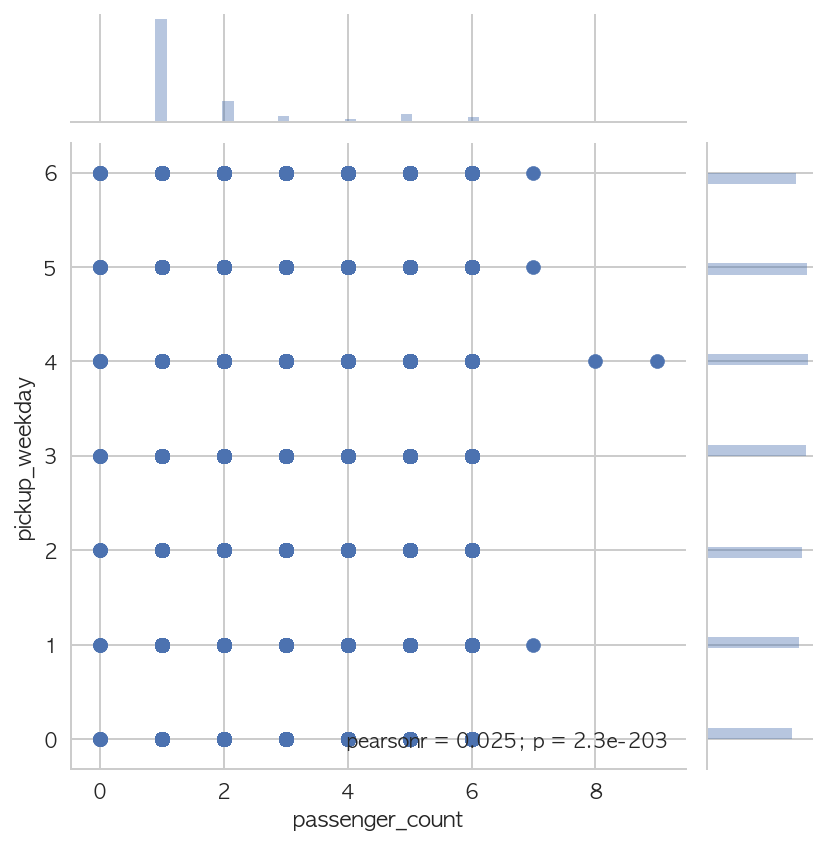

In [28]:
sns.jointplot(x="passenger_count", y="pickup_weekday", data=train)
plt.show()

##### passenger_count - 3-5. OLS - w/ pickup_month
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [33]:
model_pc5 = sm.OLS.from_formula("pickup_month ~ passenger_count", train)
result_pc5= model_pc2.fit()
print(result_pc5.summary())

                            OLS Regression Results                            
Dep. Variable:           pickup_month   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.700
Date:                Thu, 08 Mar 2018   Prob (F-statistic):            0.00964
Time:                        03:58:20   Log-Likelihood:            -2.8274e+06
No. Observations:             1458644   AIC:                         5.655e+06
Df Residuals:                 1458642   BIC:                         5.655e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5214      0.002   15

##### passenger_count - 3-6. joint plot - w/ pickup_month
- joint_plot결과, 승객수 간 승차 월 차이는 달라보이지 않음.

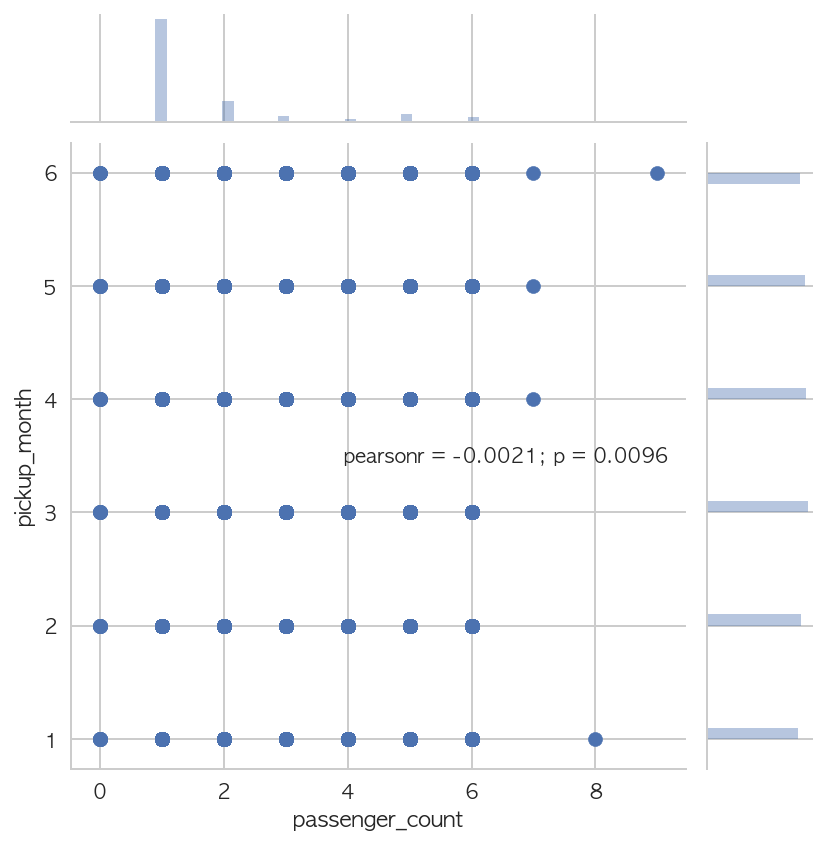

In [30]:
sns.jointplot(x="passenger_count", y="pickup_month", data=train)
plt.show()

### 2. vendor_id

##### vendor_id - 1-1. OLS - w/ trip_duration
- R-squared : 0으로 상관 없어보임.

In [34]:
model_pc6 = sm.OLS.from_formula("trip_duration ~ vendor_id", train)
result_pc6 = model_pc1.fit()
print(result_pc6.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     104.7
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           1.44e-24
Time:                        03:58:27   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458642   BIC:                         2.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         903.3010      6.998    1

##### vendor_id - 1-2. joint plot - w/ trip_duration
- 좀 더 명확하게 벤더 간 duration차이를 보기위에 일부 데이터 제거 (trip_duration > 7200)
- joint_plot결과, 벤더 간 trip_duration차이 없음

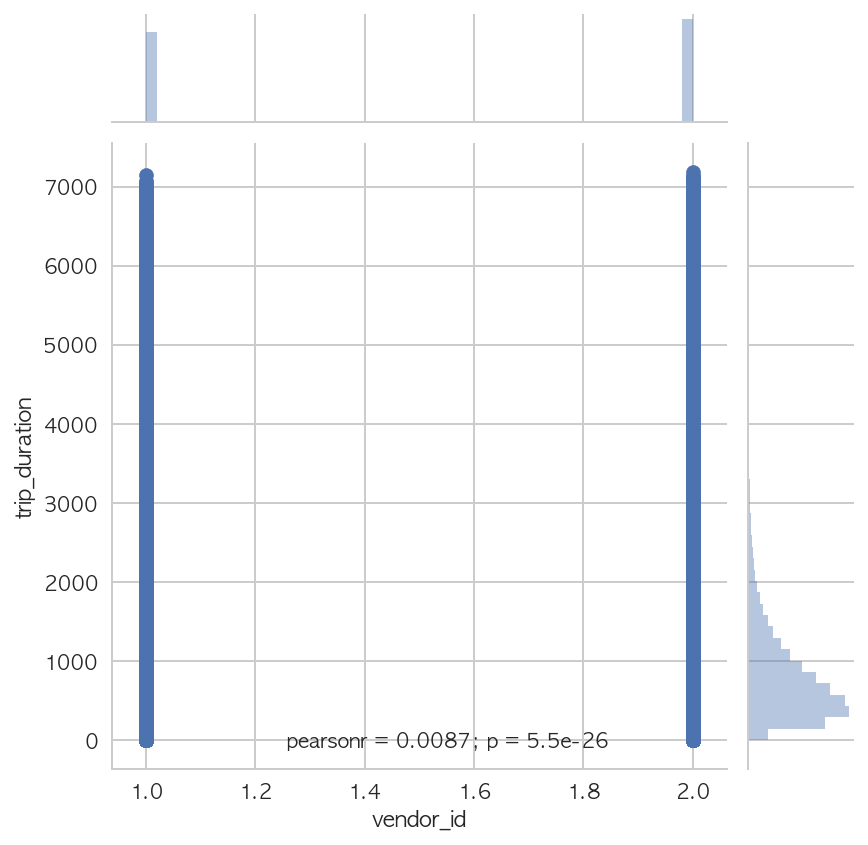

In [35]:
sns.jointplot(x="vendor_id", y="trip_duration", data=train1)
plt.show()

##### vendor_id - 2-1. OLS - w/ distance
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [36]:
model_pc7 = sm.OLS.from_formula("distance ~ vendor_id", train)
result_pc7= model_pc7.fit()
print(result_pc7.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     95.92
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           1.20e-22
Time:                        04:00:28   Log-Likelihood:            -4.1961e+06
No. Observations:             1458644   AIC:                         8.392e+06
Df Residuals:                 1458642   BIC:                         8.392e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3336      0.012    289.604      0.0

##### vendor_id - 2-2. joint plot - w/ trip_duration
- 좀 더 명확하게 벤더 간 distance차이를 보기위에 일부 데이터 제거 (distance > 600)
- joint_plot결과, 벤더 간 distance 차이는 달라보이지 않음.

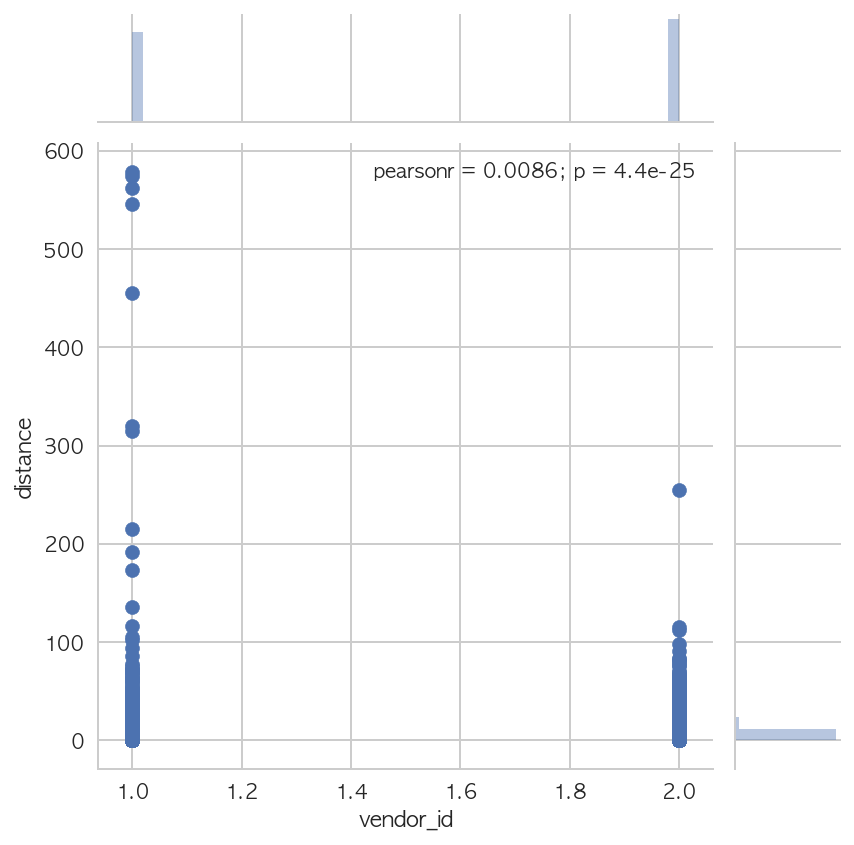

In [37]:
sns.jointplot(x="vendor_id", y="distance", data=train2)
plt.show()

##### vendor_id - 3-1. OLS - w/ pickup_hour
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [38]:
model_pc8 = sm.OLS.from_formula("pickup_hour ~ vendor_id", train)
result_pc8= model_pc8.fit()
print(result_pc8.summary())

                            OLS Regression Results                            
Dep. Variable:            pickup_hour   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     126.1
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           2.89e-29
Time:                        04:01:52   Log-Likelihood:            -4.7773e+06
No. Observations:             1458644   AIC:                         9.555e+06
Df Residuals:                 1458642   BIC:                         9.555e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4234      0.017    782.907      0.0

##### vendor_id - 3-2. joint plot - w/ pickup_hour
- joint_plot결과, 벤더 간 승차 시각 차이는 달라보이지 않음.

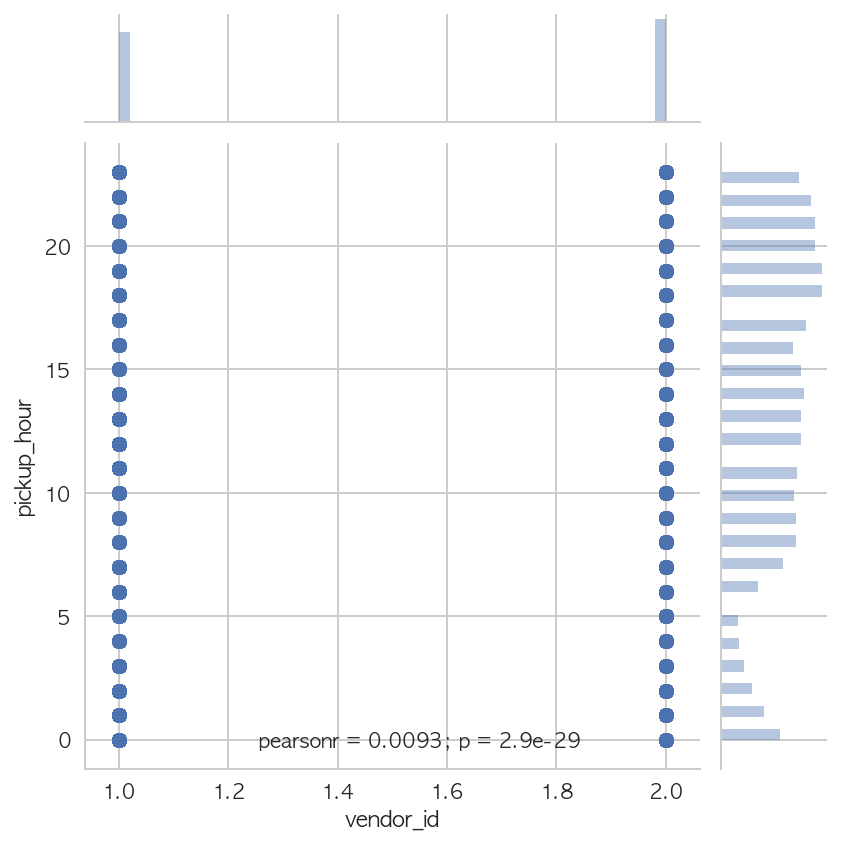

In [39]:
sns.jointplot(x="vendor_id", y="pickup_hour", data=train)
plt.show()

##### vendor_id- 3-3. OLS - w/ pickup_weekday
- OLS상으로 R-Squared = 0.000, 연관성 거의 없어 보임.

In [40]:
model_pc9 = sm.OLS.from_formula("pickup_weekday ~ vendor_id", train)
result_pc9= model_pc2.fit()
print(result_pc9.summary())

                            OLS Regression Results                            
Dep. Variable:           pickup_month   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.700
Date:                Thu, 08 Mar 2018   Prob (F-statistic):            0.00964
Time:                        04:02:59   Log-Likelihood:            -2.8274e+06
No. Observations:             1458644   AIC:                         5.655e+06
Df Residuals:                 1458642   BIC:                         5.655e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5214      0.002   15

##### vendor_id - 3-4. joint plot - w/ pickup_weekday
- joint_plot결과, 벤더 간 승차 요일 차이는 달라보이지 않음.

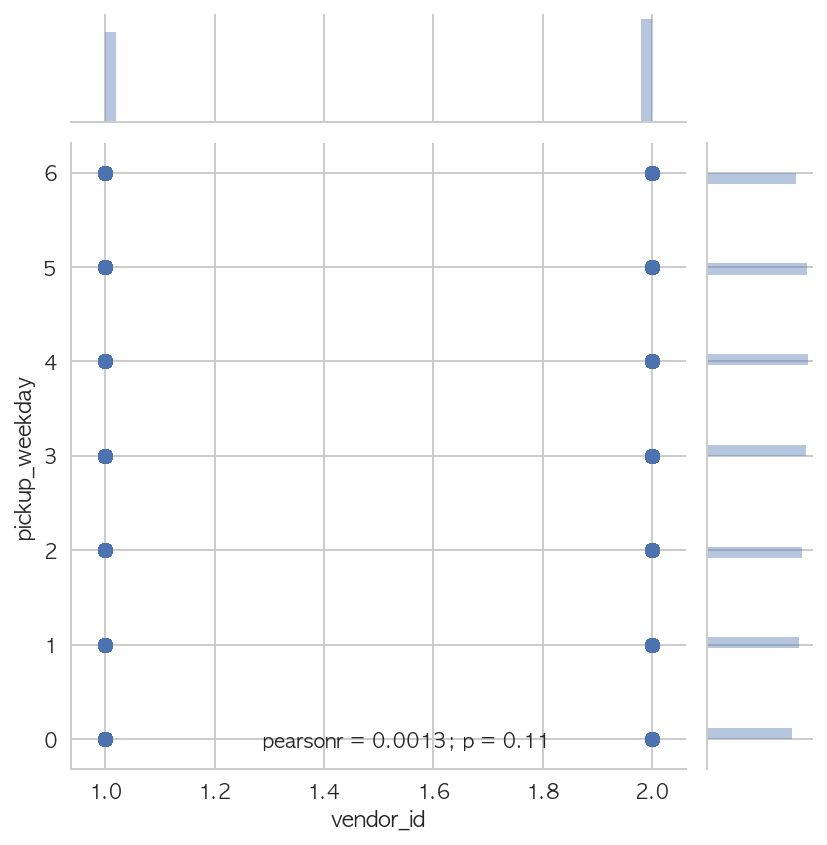

In [41]:
sns.jointplot(x="vendor_id", y="pickup_weekday", data=train)
plt.show()

##### vendor_id - 3-5. OLS - w/ pickup_month
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [43]:
model_pc10 = sm.OLS.from_formula("pickup_month ~ vendor_id", train)
result_pc10= model_pc10.fit()
print(result_pc10.summary())

                            OLS Regression Results                            
Dep. Variable:           pickup_month   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     56.44
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           5.78e-14
Time:                        04:04:16   Log-Likelihood:            -2.8273e+06
No. Observations:             1458644   AIC:                         5.655e+06
Df Residuals:                 1458642   BIC:                         5.655e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5490      0.005    788.000      0.0

##### vendor_id - 3-6. joint plot - w/ pickup_month
- joint_plot결과, 벤더 간 승차 월 차이는 달라보이지 않음.

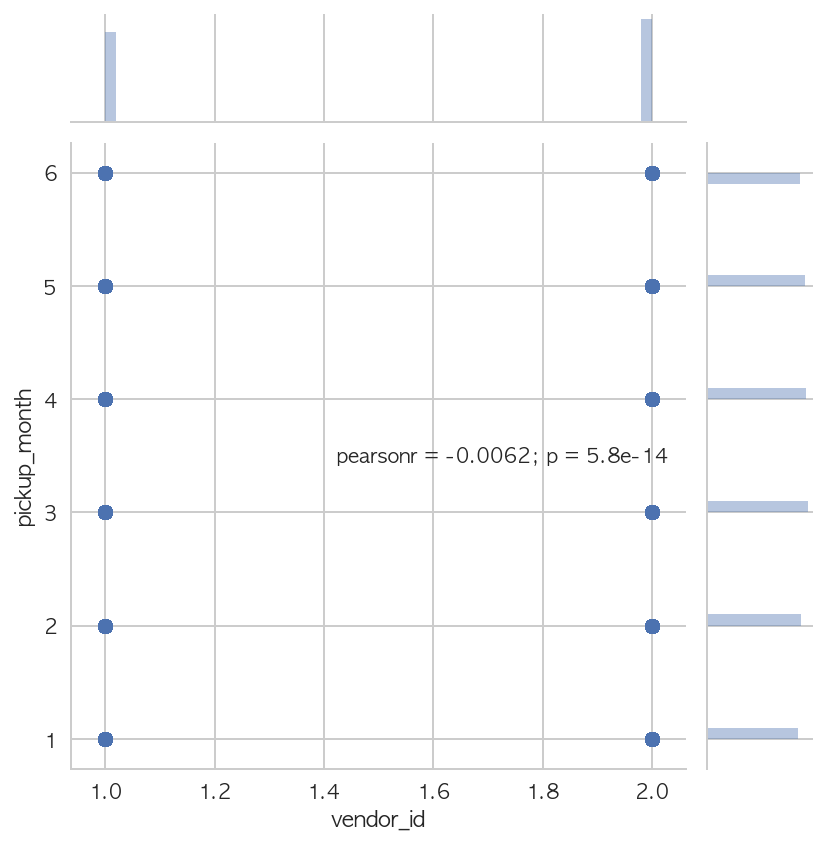

In [44]:
sns.jointplot(x="vendor_id", y="pickup_month", data=train)
plt.show()

### 3. store_and_fwd_flag

##### store_and_fwd_flag - 1-1. OLS - w/ trip_duration
- R-squared : 0으로 상관 없어보임.

In [45]:
model_pc11 = sm.OLS.from_formula("trip_duration ~ store_and_fwd_flag", train)
result_pc11 = model_pc11.fit()
print(result_pc11.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.337
Date:                Thu, 08 Mar 2018   Prob (F-statistic):             0.0373
Time:                        04:08:33   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458642   BIC:                         2.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

##### store_and_fwd_flag - 2-1. OLS - w/ distance
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [47]:
model_pc12 = sm.OLS.from_formula("distance ~ store_and_fwd_flag", train)
result_pc12= model_pc12.fit()
print(result_pc12.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1007.
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          6.47e-221
Time:                        04:10:36   Log-Likelihood:            -4.1956e+06
No. Observations:             1458644   AIC:                         8.391e+06
Df Residuals:                 1458642   BIC:                         8.391e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

##### store_and_fwd_flag - 3-1. OLS - w/ pickup_hour
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [49]:
model_pc13 = sm.OLS.from_formula("pickup_hour ~ store_and_fwd_flag", train)
result_pc13= model_pc13.fit()
print(result_pc13.summary())

                            OLS Regression Results                            
Dep. Variable:            pickup_hour   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.349
Date:                Thu, 08 Mar 2018   Prob (F-statistic):            0.00671
Time:                        04:11:51   Log-Likelihood:            -4.7773e+06
No. Observations:             1458644   AIC:                         9.555e+06
Df Residuals:                 1458642   BIC:                         9.555e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

##### store_and_fwd_flag- 3-2. OLS - w/ pickup_weekday
- OLS상으로 R-Squared = 0.000, 연관성 거의 없어 보임.

In [50]:
model_pc14 = sm.OLS.from_formula("pickup_weekday ~ store_and_fwd_flag", train)
result_pc14= model_pc14.fit()
print(result_pc14.summary())

                            OLS Regression Results                            
Dep. Variable:         pickup_weekday   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     22.78
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           1.81e-06
Time:                        04:12:24   Log-Likelihood:            -3.0469e+06
No. Observations:             1458644   AIC:                         6.094e+06
Df Residuals:                 1458642   BIC:                         6.094e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

##### store_and_fwd_flag - 3-3. OLS - w/ pickup_month
- OLS상으로 R-Squared = 0, 연관성 없어 보임.

In [51]:
model_pc15 = sm.OLS.from_formula("pickup_month ~ store_and_fwd_flag", train)
result_pc15= model_pc15.fit()
print(result_pc15.summary())

                            OLS Regression Results                            
Dep. Variable:           pickup_month   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2370
Date:                Thu, 08 Mar 2018   Prob (F-statistic):              0.626
Time:                        04:12:56   Log-Likelihood:            -2.8274e+06
No. Observations:             1458644   AIC:                         5.655e+06
Df Residuals:                 1458642   BIC:                         5.655e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 